# Imports

In [217]:
import torch
import math
import warnings
import random
import time
from botorch.models import SingleTaskGP
from botorch.models.transforms import Normalize, Standardize
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.likelihoods import GaussianLikelihood

import numpy as np
from matplotlib import pyplot as plt

import warnings

## Objective Functions (Most relevant: Rosenbrock, Ackley, Bird)

In [219]:

#2D objective functions

'''
rosenbrock:
'''
def rosenbrock(x, y, a=1, b=100):#Domain: [[-2,2],[-1,3]], global max: f(1,1)=0
    return -((a - x) ** 2 + b * (y - x ** 2) ** 2)

def ackley(x, y, a=20, b=0.2, c=2*np.pi): #Domain: [-5,5],[-5,5]], global max: f(0,0)=0
    return -(-a * np.exp(-b * np.sqrt(0.5 * (x**2 + y**2))) - np.exp(0.5 * (np.cos(c * x) + np.cos(c * y))) + np.e + a)


# def bird(x1,x2): 
#     term1 = np.sin(x2) * np.exp((1 - np.cos(x1)) ** 2)
#     term2 = np.cos(x1) * np.exp((1 - np.sin(x2)) ** 2)
#     term3 = (x1 - x2) ** 2
#     return -(term1 + term2 + term3) -106.7645367 #to shift value


#1D objective functions
def obj1DParab(x): #Domain: [-10,10]
    return -x*x

def obj1D2Peak1(x): #Domain: [-10,10]
    return -1/10*((x-7.6)**2)*(x+2)*(x+9.2)-241.579

def obj1D2Peak2(x): #Domain: [-10,10]
    return obj1D2Peak1(-x)

# selection of objective function
def pickObjFunc(s):
    if s=='ackley':
        return ackley
    if s=='rosenbrock':
        return rosenbrock
    if s=='bird':
        return bird
    if s=='1DParab':
        return obj1DParab
    if s=='1D2Peak1':
        return obj1D2Peak1
    if s=='1D2Peak2':
        return obj1D2Peak2

def getDomain(s):
    if s=='ackley':
        return [[-5,5],[-5,5]]
    if s=='rosenbrock':
        return [[-2,2],[-1,3]]
    if s=='bird':
        return [[-2*np.pi,2*np.pi],[-2*np.pi,2*np.pi]]
    if s=='1DParab':
        return [-10,10]
    if s=='1D2Peak1':
        return [-10,10]
    if s=='1D2Peak2':
        return [-10,10]

#discretizes domain into discSize pieces
def getDiscSpace(domain, discSize):
    x=torch.linspace(domain[0][0],domain[0][1],discSize)
    y=torch.linspace(domain[1][0],domain[1][1],discSize)
    X, Y = torch.meshgrid(x, y, indexing='ij')
    grid_points = torch.stack([X.flatten(), Y.flatten()], dim=1)
    return grid_points

# Regret

## Regret Definitions

In [ ]:
# Regret Definitions


def regretBestInstant_true(objFunc,dataH):
    objective=pickObjFunc(objFunc)
    T=len(dataH[0])
    reg=np.zeros((T-1,1))
    numAgents=len(dataH)
    for i in range(T-1):
        maxObj=-np.inf
        for j in range(numAgents):
            for k in range(i+1):
                pt=dataH[j][k][0]
                val=objective(pt[0],pt[1])
                if val>maxObj:
                    maxObj=val
        reg[i,0]=max(0,0-maxObj)
    return reg
        
    
def regretCumulative_true(reg):
    T=len(reg)
    regCum=np.zeros((T,1))
    for i in range(T):
        regCum[i,0]=np.sum(reg[0:i+1,0])
    return regCum

def regretSumInstant_true(objFunc,dataH):
    objective=pickObjFunc(objFunc)
    T=len(dataH[0])
    numAgents=len(dataH)
    reg=np.zeros((T,1))
    for i in range(T):
        s=0
        for j in range(numAgents):
            pt=dataH[j][i][0]
            s+=objective(pt[0],pt[1])
        reg[i,0]=0-s
    return reg


def regretAvgInstant_true(objFunc,dataH):
    objective=pickObjFunc(objFunc)
    T=len(dataH[0])
    numAgents=len(dataH)
    reg=np.zeros((T,1))
    for i in range(T):
        s=0
        for j in range(numAgents):
            pt=dataH[j][i][0]
            s+=objective(pt[0],pt[1])
        reg[i,0]=(0-s)/numAgents
    return reg

def worstRegret_true(objFunc,dataH):
    objective=pickObjFunc(objFunc)
    T=len(dataH[0])
    numAgents=len(dataH)
    reg=np.zeros((T,1))
    for i in range(T):
        minObj=np.inf
        for j in range(numAgents):
            pt=dataH[j][i][0]
            val=objective(pt[0],pt[1])
            if val<minObj:
                minObj=val
        reg[i,0]=0-minObj
    return reg


def getAllRegrets_true(objFunc,dataH):
    regHI=regretBestInstant_true(objFunc,dataH)
    regHCum=regretCumulative_true(regHI)
    regSumI=regretSumInstant_true(objFunc,dataH)
    regSumCum=regretCumulative_true(regSumI)
    regAvgI=regretAvgInstant_true(objFunc,dataH)
    regAvgCum=regretCumulative_true(regAvgI)
    regWorstI=worstRegret_true(objFunc,dataH)
    regWorstCum=regretCumulative_true(regWorstI)
    return regHI,regHCum,regSumI,regSumCum,regAvgI,regAvgCum,regWorstI,regWorstCum

## Regret Plotting Functions

In [ ]:
### PLOTS
def plotRegretsMultCaseWithVar_true(objFunc,dataHists,label):
    regInsts,regCums,regInstSums,regSumCums,regAvgInsts,regAvgCums,regWorstIs,regWorstCums=[],[],[],[],[],[],[],[]
    for i in range(len(dataHists)):
        regInsts1,regCums1,regInstSums1,regSumCums1,regAvgInsts1,regAvgCums1,regWorstIs1,regWorstCums1=[],[],[],[],[],[],[],[]
        for j in range(len(dataHists[i])):
            regInst,regCum,regInstSum,regSumCum,regAvgI,regAvgCum,regWorstI,regWorstCum=getAllRegrets_true(objFunc,dataHists[i][j])
            regInsts1.append(regInst)
            regCums1.append(regCum)
            regInstSums1.append(regInstSum)
            regSumCums1.append(regSumCum)
            regAvgInsts1.append(regAvgI)
            regAvgCums1.append(regAvgCum)
            regWorstIs1.append(regWorstI)
            regWorstCums1.append(regWorstCum)
        regInsts.append(regInsts1)
        regCums.append(regCums1)
        regInstSums.append(regInstSums1)
        regSumCums.append(regSumCums1)
        regAvgInsts.append(regAvgInsts1)
        regAvgCums.append(regAvgCums1)
        regWorstIs.append(regWorstIs1)
        regWorstCums.append(regWorstCums1)
    
    def miniPlot(reg,yAx,label):
        fig=plt.figure(figsize=(7, 5))
        ax_position = [0.15, 0.15, 0.8, 0.8]
        ax = fig.add_axes(ax_position)
        for i in range(len(reg)):
            plt.rcParams.update({'font.size':15})
            mean=np.mean(np.array(reg[i]), axis=0).flatten()
            std=np.std(np.array(reg[i]), axis=0).flatten()
            plt.plot(mean,label=label[i])
            plt.fill_between(range(len(mean)), mean-std, mean+std, alpha=0.2)
            plt.xlabel("iterations",fontsize=20)
            plt.ylabel(yAx, fontsize=20)
            plt.ylim(bottom=-.1)
        plt.legend()
        plt.show()
    
    miniPlot(regInsts, 'instant simple regret', label)
    miniPlot(regCums, 'cumulative simple regret', label)
    miniPlot(regInstSums, 'instant summed regret', label)    
    miniPlot(regSumCums, 'cumulative summed regret', label)
    miniPlot(regAvgInsts, 'instant average regret', label)
    miniPlot(regAvgCums, 'cumulative average regret', label)
    miniPlot(regWorstIs, 'instant worst regret', label)
    miniPlot(regWorstCums, 'cumulative worst regret', label)

# Auxiliary Functions

In [25]:
def edgelistToAdjMtx(numAgents,edgeList):
    adjMtx=np.zeros((numAgents,numAgents))
    for vtxPair in edgeList:
        i,j=vtxPair
        adjMtx[i,j]=1
        adjMtx[j,i]=1
    return adjMtx

# Inefficient; can use DFS and check visited vertex list. But this uses cool combinatoric trick
def checkConnectivity(numAgents,edgeList):
    adjMtx=edgelistToAdjMtx(numAgents,edgeList)
    res=np.linalg.matrix_power(adjMtx,numAgents-1)+np.linalg.matrix_power(adjMtx,numAgents-2)
    return np.all(res>0)

# constructs adjacency matrix for 
def makeCommGraph(numAgents,graph,connectProb=0.25,seed=0):#0 indexed
    adjMtx=np.zeros((numAgents,numAgents))
    edgeList=[]
    if graph=='linear':
        edgeList=[(i,i+1) for i in range(numAgents-1)]
    if graph=='star':
        edgeList=[(0,i) for i in range(1,numAgents)]
    if graph=='complete':
        edgeList=[(i,j) for i in range(numAgents) for j in range(i+1,numAgents)]
    if graph=='disjoint':
        edgeList=[]
    if graph=='erdos-renyi':
        random.seed(seed)
        connected=False
        while not connected:
            edgeList=[(i,j) for i in range(numAgents) for j in range(i+1,numAgents) if random.random()<connectProb]
            connected=checkConnectivity(numAgents,edgeList)
    return edgelistToAdjMtx(numAgents,edgeList)

def commDataForAgent(agent,commGraph,commHist,dataHist,t):
    agentData=[]
    agentObs=[]
    neighbors=commGraph[agent,:]
    agentData=dataHist[agent][t][0].unsqueeze(0)
    agentObs=dataHist[agent][t][1].unsqueeze(0)
    for i in range(len(neighbors)):
        if(neighbors[i]==1):
            agentData=torch.cat([agentData,commHist[i][t][0].unsqueeze(0)])
            agentObs=torch.cat([agentObs,commHist[i][t][1].unsqueeze(0)])

    return agentData,agentObs 

def admissiblePoints(admissRad,discSpace,refPoint):
    distances = torch.norm(discSpace - refPoint, dim=1)

    within_distance_indices = torch.where(distances <= admissRad)[0]

    return discSpace[within_distance_indices]

In [20]:
def runBO(numAgents=5,initSize=10,totalT=100,discSize=100,eps=.1,graph='complete',seed=0,objFunc='ackley',admissRad=1):

    #initialize randomization
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    #initialize setting parameters
    commGraph=graph #communication structure
    objective=pickObjFunc(objFunc) #objective function
    domain=getDomain(objFunc) #objective function domain
    discSpace=getDiscSpace(domain,discSize) #discretization 
    
    visitHist=[[] for i in range(numAgents)]
    commHist=[[] for i in range(numAgents)]
    updateHistPts=[[] for i in range(numAgents)]
    updateHistVals=[[] for i in range(numAgents)]
    gpList=[]

    #initializing Thompson sampling
    for agent in range(numAgents):
        train_X1=torch.rand(initSize, 1, dtype=torch.double)*(domain[0][1]-domain[0][0])+domain[0][0]
        train_X2=torch.rand(initSize, 1, dtype=torch.double)*(domain[1][1]-domain[1][0])+domain[1][0]
        train_X=torch.cat((train_X1,train_X2),dim=1)
        trainYs=[[objective(train_X[i][0].item(),train_X[i][1].item())+torch.randn(1)*eps] for i in range(len(train_X))]
        train_Y=torch.tensor(trainYs,dtype=torch.double)
        gp=SingleTaskGP(
        train_X=train_X,
        train_Y=train_Y,
        likelihood=GaussianLikelihood(),
        input_transform=Normalize(d=2),
        outcome_transform=Standardize(m=1),
        )
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        fit_gpytorch_mll(mll)
        gp(train_X)
        gpList.append(gp)
        best_index = torch.argmax(train_Y)
        visitHist[agent].append((train_X[best_index],train_Y[best_index]))
        commHist[agent].append((train_X[best_index],train_Y[best_index]))
        updateHistPts[agent]=train_X
        updateHistVals[agent]=train_Y

    for t in range(totalT):
        for agent in range(numAgents):
            agentData, agentObs=commDataForAgent(agent,commGraph,commHist,visitHist,t)
            
            updateHistPts[agent]=torch.cat([updateHistPts[agent], agentData])
            updateHistVals[agent]=torch.cat([updateHistVals[agent], agentObs])

            gpList[agent] = SingleTaskGP(
            train_X=updateHistPts[agent],
            train_Y=updateHistVals[agent],
            likelihood=GaussianLikelihood(),
            input_transform=Normalize(d=2),
            outcome_transform=Standardize(m=1),
            )
            mll = ExactMarginalLogLikelihood(gpList[agent].likelihood, gpList[agent])
            fit_gpytorch_mll(mll)
            
            #Thompson sampling
            candidatePoints=admissiblePoints(admissRad,discSpace,visitHist[agent][t][0]) 
            posterior_samples = torch.zeros(candidatePoints.size(0))
            for j, point in enumerate(candidatePoints):
                posterior = gpList[agent].posterior(point.unsqueeze(0))
                posterior_samples[j] = posterior.rsample(sample_shape=torch.Size([1]))
                
            #find the maximum of the posterior samples
            max_index = torch.argmax(posterior_samples)
            max_point = candidatePoints[max_index]
            
            #evaluate objective function where we think max value is
            objVal=objective(max_point[0],max_point[1])+torch.randn(1)*(eps**0.5)
            
            #update dataHistory 
            visitHist[agent].append((max_point,objVal))
            commHist[agent].append((max_point,objVal))

    print(f"completed runBO with {objFunc} objective function, {graph} graph, {numAgents} agents, {totalT} iterations")
    return visitHist
    

# Executions!

## Paper Figures

In [22]:

numTrials=5
connectProb=[0.2,0.4,0.6]
numAgents=20

rosenbrock_ER3=[]
warnings.filterwarnings("ignore")

for c in connectProb:
    agentDataH=[]
    ER=makeCommGraph(numAgents,'erdos-renyi',connectProb=c,seed=c*65+6)
    agentDataH+=[runBO(numAgents=numAgents,initSize=10,totalT=50,discSize=101,eps=10,graph=ER,seed=82*j+65,objFunc='rosenbrock',admissRad=1) for j in range(numTrials)]
    rosenbrock_ER3.append(agentDataH)
    print(f"Finished {c} case")
    
print(time.time()-start)


completed runBO with rosenbrock objective function, [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0

In [34]:
start=time.time()
numTrials=5
connectProb=[0.2,0.4,0.6]
numAgents=20

ackley_ER3=[]
warnings.filterwarnings("ignore")

for c in connectProb:
    agentDataH=[]
    ER=makeCommGraph(numAgents,'erdos-renyi',connectProb=c,seed=c*65+6)
    agentDataH+=[runBO(numAgents=numAgents,initSize=10,totalT=50,discSize=101,eps=1,graph=ER,seed=82*j+65,objFunc='ackley',admissRad=1) for j in range(numTrials)]
    ackley_ER3.append(agentDataH)
    print(f"Finished {c} case")
    
print(time.time()-start)


completed runBO with ackley objective function, [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0.

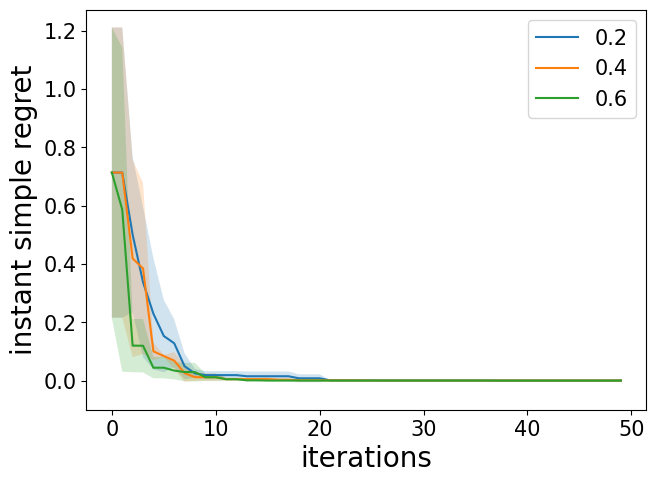

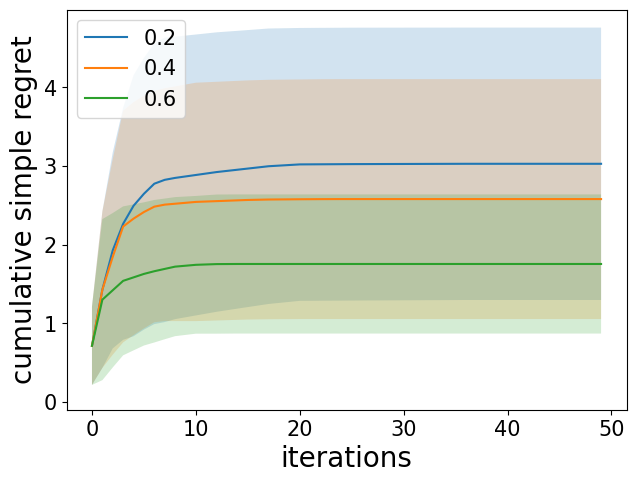

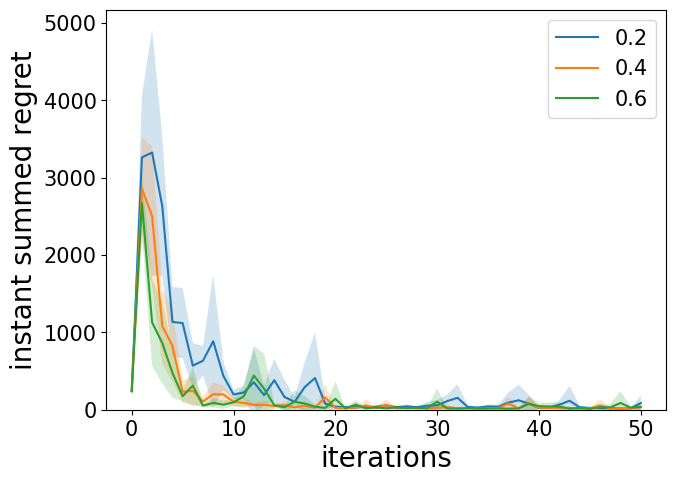

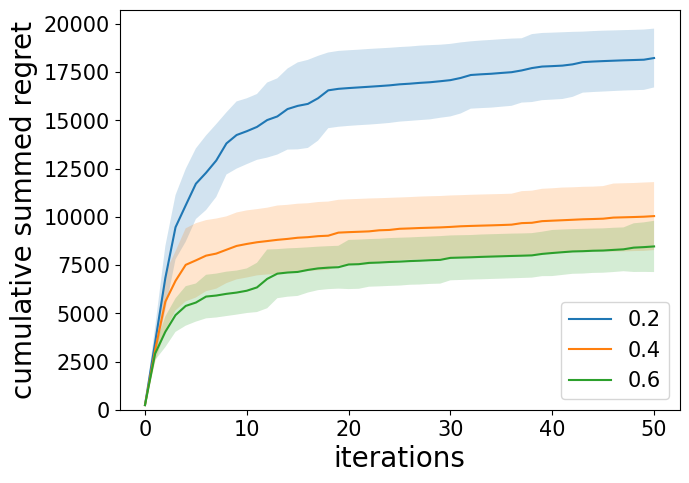

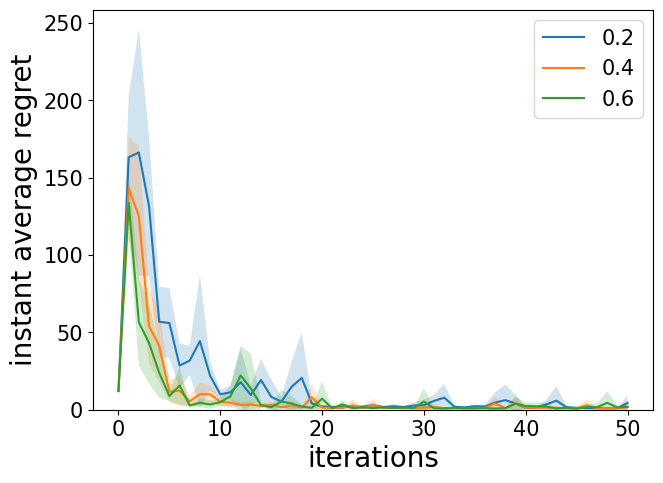

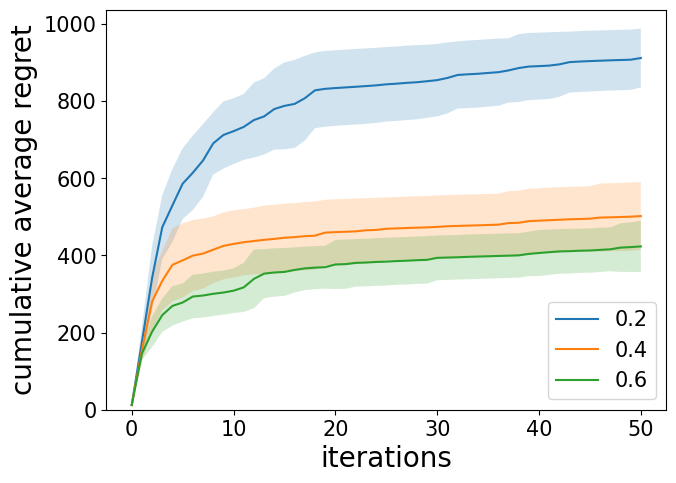

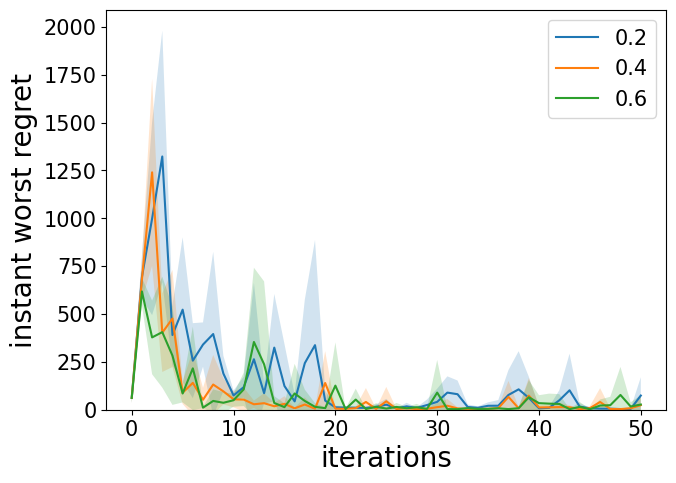

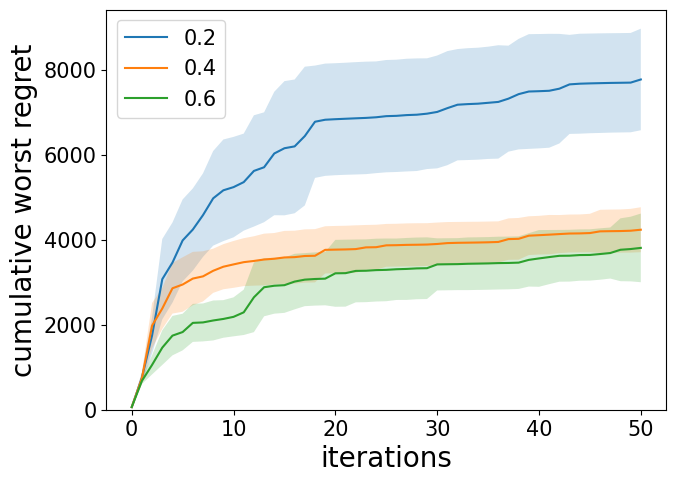

In [91]:
plotRegretsMultCaseWithVar_true('rosenbrock',rosenbrock_ER3,[0.2,0.4,0.6])

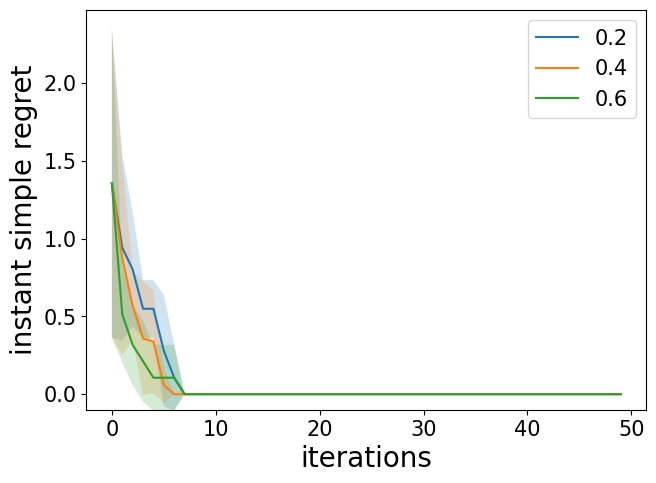

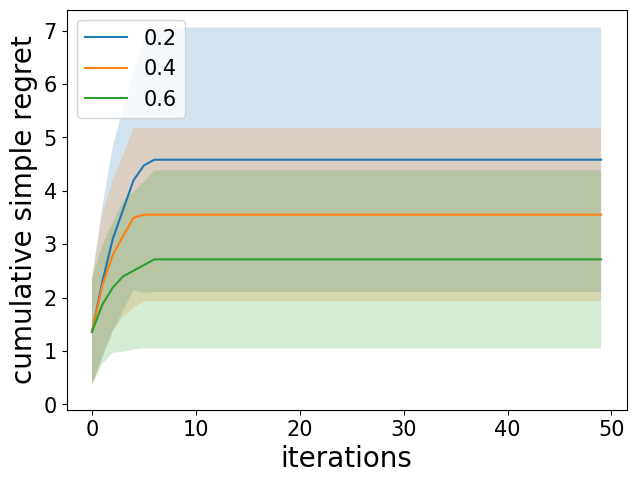

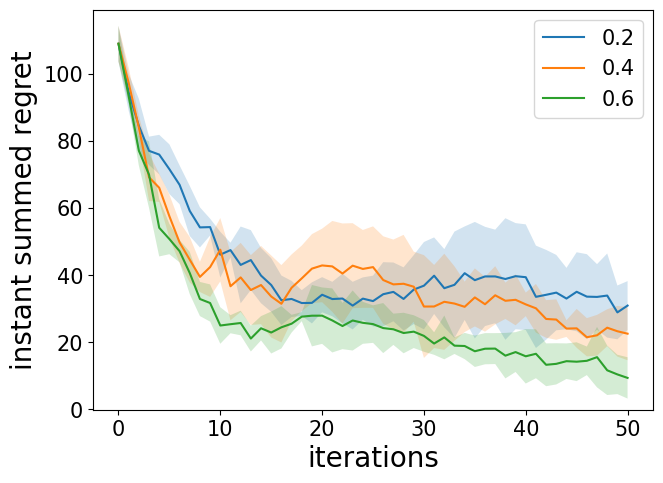

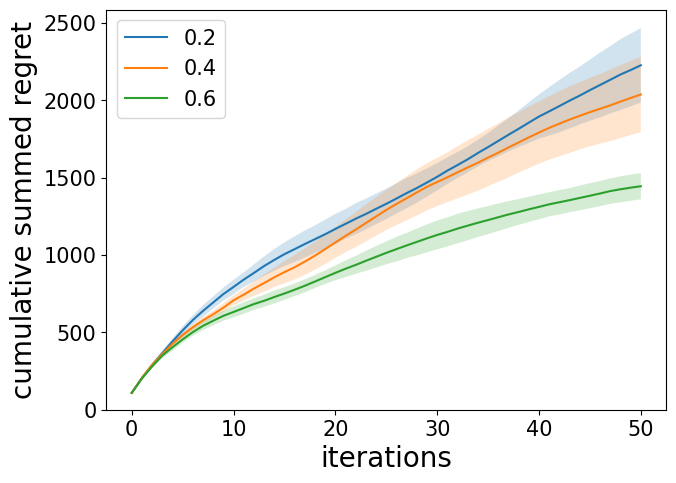

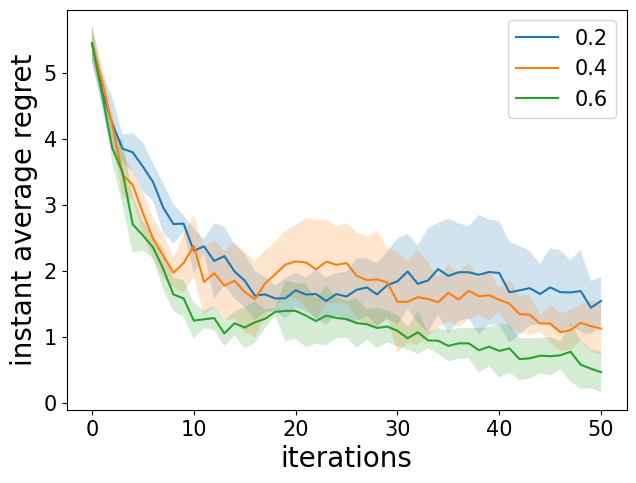

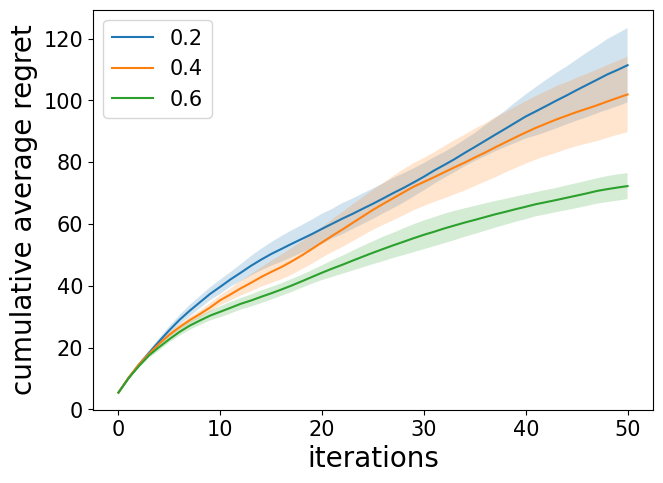

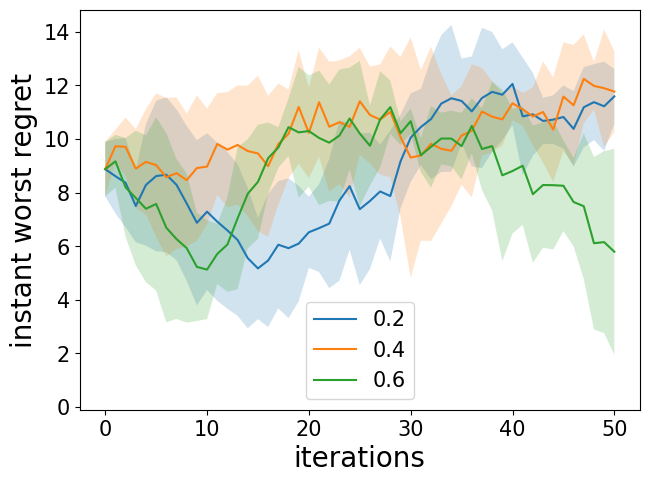

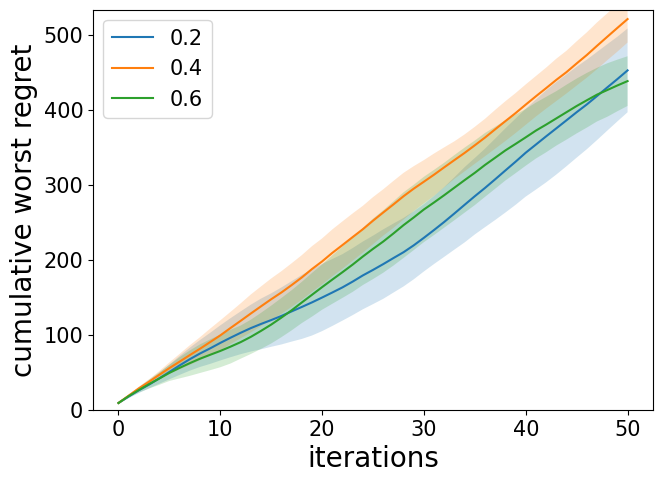

In [90]:
plotRegretsMultCaseWithVar_true('ackley',ackley_ER3,[0.2,0.4,0.6])